In [3]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xroms
from scipy import signal
import matplotlib.pyplot as plt
import cmocean as cmo

plt.rcParams.update({'font.size': 14})

### Open dataset and generate xgcm grid. Note we can't use xroms open_netcdf & open_dataset functions because we are missing lat and lon coordinates

In [8]:
def roms_dataset(ds, Vtransform=None, add_verts=False, proj=None):
    """Modify Dataset to be aware of ROMS coordinates, with matching xgcm grid object.
    Inputs
    ------
    ds: Dataset
        xarray Dataset with model output
    Vtransform: int, optional
        Vertical transform for ROMS model. Should be either 1 or 2 and only needs
        to be input if not available in ds.
    add_verts: boolean, optional
        Add 'verts' horizontal grid to ds if True. This requires a cartopy projection
        to be input too.
    proj: cartopy crs projection, optional
        Should match geographic area of model domain. Required if `add_verts=True`,
        otherwise not used. Example:
        >>> proj = cartopy.crs.LambertConformal(central_longitude=-98, central_latitude=30)
    Returns
    -------
    ds: Dataset
        Same dataset as input, but with dimensions renamed to be consistent with `xgcm` and
        with vertical coordinates and metrics added.
    grid: xgcm grid object
        Includes ROMS metrics so can be used for xgcm grid operations, which mostly have
        been wrapped into xroms.
    Notes
    -----
    Note that this could be very slow if dask is not on.
    This does not need to be run by the user if `xroms` functions `open_netcdf` or
    `open_zarr` are used for reading in model output, since run in those functions.
    This also uses `cf-xarray` to manage dimensions of variables.
    Example usage
    -------------
    >>> ds, grid = xroms.roms_dataset(ds)
    """

    if add_verts:
        assert proj is not None, 'To add "verts" grid, input projection "proj".'

    rename = {}
    if "eta_u" in ds.dims:
        rename["eta_u"] = "eta_rho"
    if "xi_v" in ds.dims:
        rename["xi_v"] = "xi_rho"
    if "xi_psi" in ds.dims:
        rename["xi_psi"] = "xi_u"
    if "eta_psi" in ds.dims:
        rename["eta_psi"] = "eta_v"
    ds = ds.rename(rename)

    #     ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    # modify attributes for using cf-xarray
    tdims = [dim for dim in ds.dims if dim[:3] == "xi_"]
    for dim in tdims:
        ds[dim] = (dim, np.arange(ds.sizes[dim]), {"axis": "X"})
    tdims = [dim for dim in ds.dims if dim[:4] == "eta_"]
    for dim in tdims:
        ds[dim] = (dim, np.arange(ds.sizes[dim]), {"axis": "Y"})
    ds.ocean_time.attrs["axis"] = "T"
    ds.ocean_time.attrs["standard_name"] = "time"
    tcoords = [coord for coord in ds.coords if coord[:2] == "s_"]
    for coord in tcoords:
        ds[coord].attrs["axis"] = "Z"
    # make sure lon/lat have standard names
    tcoords = [coord for coord in ds.coords if coord[:4] == "lon_"]
    for coord in tcoords:
        ds[coord].attrs["standard_name"] = "longitude"
    tcoords = [coord for coord in ds.coords if coord[:4] == "lat_"]
    for coord in tcoords:
        ds[coord].attrs["standard_name"] = "latitude"

    coords = {
        "X": {"center": "xi_rho", "inner": "xi_u"},
        "Y": {"center": "eta_rho", "inner": "eta_v"},
        "Z": {"center": "s_rho", "outer": "s_w"},
    }

    grid = xgcm.Grid(ds, coords=coords, periodic=[])

    if "Vtransform" in ds.variables.keys():
        Vtransform = ds.Vtransform

    assert (
        Vtransform is not None
    ), "Need a Vtransform of 1 or 2, either in the Dataset or input to the function."

    if Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho / ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w / ds.h)
        # also include z coordinates with mean sea level (constant over time)
        z_rho0 = Zo_rho
        z_w0 = Zo_w
    elif Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w
        # also include z coordinates with mean sea level (constant over time)
        z_rho0 = ds.h * Zo_rho
        z_w0 = ds.h * Zo_w

    ds.coords["z_w"] = z_w.cf.transpose(
        *[dim for dim in ["T", "Z", "Y", "X"] if dim in z_w.cf.get_valid_keys()]
    )
    #     ds.coords['z_w'] = z_w.transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho', transpose_coords=False)
    ds.coords["z_w_u"] = grid.interp(ds.z_w, "X")
    ds.coords["z_w_v"] = grid.interp(ds.z_w, "Y")
    ds.coords["z_w_psi"] = grid.interp(ds.z_w_u, "Y")

    ds.coords["z_rho"] = z_rho.cf.transpose(
        *[dim for dim in ["T", "Z", "Y", "X"] if dim in z_rho.cf.get_valid_keys()]
    )
    #     ds.coords['z_rho'] = z_rho.transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho', transpose_coords=False)
    ds.coords["z_rho_u"] = grid.interp(ds.z_rho, "X")
    ds.coords["z_rho_v"] = grid.interp(ds.z_rho, "Y")
    ds.coords["z_rho_psi"] = grid.interp(ds.z_rho_u, "Y")
    # also include z coordinates with mean sea level (constant over time)
    ds.coords["z_rho0"] = z_rho0.cf.transpose(
        *[dim for dim in ["T", "Z", "Y", "X"] if dim in z_rho0.cf.get_valid_keys()]
    )
    #     ds.coords['z_rho0'] = z_rho0.transpose('s_rho', 'eta_rho', 'xi_rho', transpose_coords=False)
    ds.coords["z_rho_u0"] = grid.interp(ds.z_rho0, "X")
    ds.coords["z_rho_v0"] = grid.interp(ds.z_rho0, "Y")
    ds.coords["z_rho_psi0"] = grid.interp(ds.z_rho_u0, "Y")
    ds.coords["z_w0"] = z_w0.cf.transpose(
        *[dim for dim in ["T", "Z", "Y", "X"] if dim in z_w0.cf.get_valid_keys()]
    )
    #     ds.coords['z_w0'] = z_w0.transpose('s_w', 'eta_rho', 'xi_rho', transpose_coords=False)
    ds.coords["z_w_u0"] = grid.interp(ds.z_w0, "X")
    ds.coords["z_w_v0"] = grid.interp(ds.z_w0, "Y")
    ds.coords["z_w_psi0"] = grid.interp(ds.z_w_u0, "Y")

    # add vert grid, esp for plotting pcolormesh
    if add_verts:
        import pygridgen

        pc = cartopy.crs.PlateCarree()
        # project points for this calculation
        xr, yr = proj.transform_points(pc, ds.lon_rho.values, ds.lat_rho.values)[
            ..., :2
        ].T
        xr = xr.T
        yr = yr.T
        # calculate vert locations
        xv, yv = pygridgen.grid.rho_to_vert(xr, yr, ds.pm, ds.pn, ds.angle)
        # project back
        lon_vert, lat_vert = pc.transform_points(proj, xv, yv)[..., :2].T
        lon_vert = lon_vert.T
        lat_vert = lat_vert.T
        # add new coords to ds
        ds.coords["lon_vert"] = (("eta_vert", "xi_vert"), lon_vert)
        ds.coords["lat_vert"] = (("eta_vert", "xi_vert"), lat_vert)

    ds["pm_v"] = grid.interp(ds.pm, "Y")
    ds["pn_u"] = grid.interp(ds.pn, "X")
    ds["pm_u"] = grid.interp(ds.pm, "X")
    ds["pn_v"] = grid.interp(ds.pn, "Y")
    ds["pm_psi"] = grid.interp(
        grid.interp(ds.pm, "Y"), "X"
    )  # at psi points (eta_v, xi_u)
    ds["pn_psi"] = grid.interp(
        grid.interp(ds.pn, "X"), "Y"
    )  # at psi points (eta_v, xi_u)

    ds["dx"] = 1 / ds.pm
    ds["dx_u"] = 1 / ds.pm_u
    ds["dx_v"] = 1 / ds.pm_v
    ds["dx_psi"] = 1 / ds.pm_psi

    ds["dy"] = 1 / ds.pn
    ds["dy_u"] = 1 / ds.pn_u
    ds["dy_v"] = 1 / ds.pn_v
    ds["dy_psi"] = 1 / ds.pn_psi

    ds["dz"] = grid.diff(ds.z_w, "Z")
    ds["dz_w"] = grid.diff(ds.z_rho, "Z", boundary="fill")
    ds["dz_u"] = grid.interp(ds.dz, "X")
    ds["dz_w_u"] = grid.interp(ds.dz_w, "X")
    ds["dz_v"] = grid.interp(ds.dz, "Y")
    ds["dz_w_v"] = grid.interp(ds.dz_w, "Y")
    ds["dz_psi"] = grid.interp(ds.dz_v, "X")
    ds["dz_w_psi"] = grid.interp(ds.dz_w_v, "X")

    # also include z coordinates with mean sea level (constant over time)
    ds["dz0"] = grid.diff(ds.z_w0, "Z")
    ds["dz_w0"] = grid.diff(ds.z_rho0, "Z", boundary="fill")
    ds["dz_u0"] = grid.interp(ds.dz0, "X")
    ds["dz_w_u0"] = grid.interp(ds.dz_w0, "X")
    ds["dz_v0"] = grid.interp(ds.dz0, "Y")
    ds["dz_w_v0"] = grid.interp(ds.dz_w0, "Y")
    ds["dz_psi0"] = grid.interp(ds.dz_v0, "X")
    ds["dz_w_psi0"] = grid.interp(ds.dz_w_v0, "X")

    # grid areas
    ds["dA"] = ds.dx * ds.dy
    ds["dA_u"] = ds.dx_u * ds.dy_u
    ds["dA_v"] = ds.dx_v * ds.dy_v
    ds["dA_psi"] = ds.dx_psi * ds.dy_psi

    # volume
    ds["dV"] = ds.dz * ds.dx * ds.dy  # rho vertical, rho horizontal
    ds["dV_w"] = ds.dz_w * ds.dx * ds.dy  # w vertical, rho horizontal
    ds["dV_u"] = ds.dz_u * ds.dx_u * ds.dy_u  # rho vertical, u horizontal
    ds["dV_w_u"] = ds.dz_w_u * ds.dx_u * ds.dy_u  # w vertical, u horizontal
    ds["dV_v"] = ds.dz_v * ds.dx_v * ds.dy_v  # rho vertical, v horizontal
    ds["dV_w_v"] = ds.dz_w_v * ds.dx_v * ds.dy_v  # w vertical, v horizontal
    ds["dV_psi"] = ds.dz_psi * ds.dx_psi * ds.dy_psi  # rho vertical, psi horizontal
    ds["dV_w_psi"] = ds.dz_w_psi * ds.dx_psi * ds.dy_psi  # w vertical, psi horizontal

    if "rho0" not in ds:
        ds["rho0"] = 1025  # kg/m^3
    if "positive" in ds.s_rho.attrs:
        ds.s_rho.attrs.pop("positive")
    if "positive" in ds.s_w.attrs:
        ds.s_w.attrs.pop("positive")
    #     ds['z_rho'].attrs['positive'] = 'up'
    tcoords = [coord for coord in ds.coords if coord[:2] == "z_" and "0" not in coord]
    for coord in tcoords:
        ds[coord].attrs["positive"] = "up"
    #         ds[dim] = (dim, np.arange(ds.sizes[dim]), {'axis': 'Y'})
    #     ds['z_rho'].attrs['vertical'] = 'depth'
    #     ds['temp'].attrs['coordinates'] = 'lon_rho lat_rho z_rho ocean_time'
    #     [del ds[var].encoding['coordinates'] for var in ds.variables if 'coordinates' in ds[var].encoding]
    for var in ds.variables:
        if "coordinates" in ds[var].encoding:
            del ds[var].encoding["coordinates"]

    metrics = {
        ("X",): ["dx", "dx_u", "dx_v", "dx_psi"],  # X distances
        ("Y",): ["dy", "dy_u", "dy_v", "dy_psi"],  # Y distances
        ("Z",): [
            "dz",
            "dz_u",
            "dz_v",
            "dz_w",
            "dz_w_u",
            "dz_w_v",
            "dz_psi",
            "dz_w_psi",
        ],  # Z distances
        ("X", "Y"): ["dA"],  # Areas
    }
    grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=[])

    #     ds.attrs['grid'] = grid  # causes recursion error
    # also put grid into every variable with at least 2D
    for var in ds.variables:
        if ds[var].ndim > 1:
            ds[var].attrs["grid"] = grid

    return ds, grid


def open_netcdf(
    file,
    chunks={"ocean_time": 1},
    xrargs={},
    Vtransform=None,
    add_verts=False,
    proj=None,
):
    """Return Dataset based on a single thredds or physical location.
    Inputs
    ------
    file: str
        Where to find the model output. `file` could be:
        * a string of a single netCDF file name, or
        * a string of a thredds server address containing model output.
    chunks: dict, optional
        The specified chunks for the Dataset. Use chunks to read in output using dask.
    xrargs: dict, optional
        Keyword arguments to be passed to `xarray.open_dataset`. See `xarray` docs
        for options.
    Vtransform: int, optional
        Vertical transform for ROMS model. Should be either 1 or 2 and only needs
        to be input if not available in ds.
    add_verts: boolean, optional
        Add 'verts' horizontal grid to ds if True. This requires a cartopy projection
        to be input too. This is passed to `roms_dataset`.
    proj: cartopy crs projection, optional
        Should match geographic area of model domain. Required if `add_verts=True`,
        otherwise not used. This is passed to `roms_dataset`. Example:
        >>> proj = cartopy.crs.LambertConformal(central_longitude=-98, central_latitude=30)
    Returns
    -------
    ds: Dataset
        Model output, read into an `xarray` Dataset. If 'chunks' keyword
        argument is input, dask is used when reading in model output and
        output is read in lazily instead of eagerly.
    Example usage
    -------------
    >>> ds = xroms.open_netcdf(file)
    """

    words = "Model location should be given as string. If have list of multiple locations, use `open_mfdataset`."
    assert isinstance(file, str), words

    ds = xr.open_dataset(file, chunks=chunks, **xrargs)

    # modify Dataset with useful ROMS z coords and make xgcm grid operations usable.
    ds, grid = roms_dataset(ds, Vtransform=Vtransform, add_verts=add_verts, proj=proj)

    return ds

In [55]:
paths = '/scratch/user/dylan.schlichting/shelfstrait/project/shelf_wind_5_case_his.nc'
print('loading data')  
ds = open_netcdf(paths, 
                 chunks = {'ocean_time':1})
ds, grid = roms_dataset(ds, 
                        Vtransform = None)

xislice=slice(10,20)
etaslice=slice(10,20)

loading data


<ipython-input-62-d2ce0c82d737>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(sNS.xi_rho,sNS.eta_v, sNS[0,-1], color = 'r')
<ipython-input-62-d2ce0c82d737>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(sEW.xi_u,sEW.eta_rho, sEW[0,-1], color = 'r')
<ipython-input-62-d2ce0c82d737>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the cor

(8.0, 21.0)

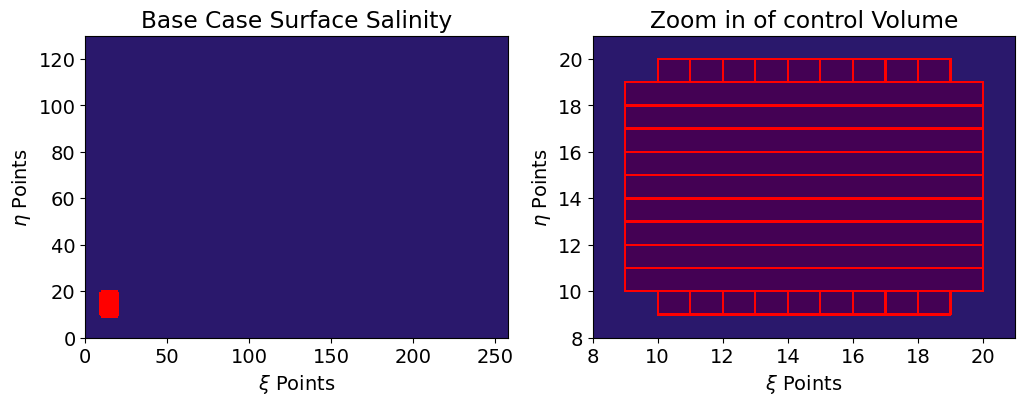

In [62]:
su = grid.interp(ds.salt, 'X')
sv = grid.interp(ds.salt, 'Y')

sEW = su.isel(eta_rho= etaslice, xi_u = [xislice.start-1, xislice.stop])
sNS = sv.isel(eta_v = [etaslice.start-1, etaslice.stop], xi_rho = xislice)

fig, ax = plt.subplots(1,2, figsize = (12,4), dpi = 100)

ax[0].pcolormesh(ds.salt[1,-1], cmap = cmo.cm.haline)
ax[0].pcolormesh(sNS.xi_rho,sNS.eta_v, sNS[0,-1], color = 'r')
ax[0].pcolormesh(sEW.xi_u,sEW.eta_rho, sEW[0,-1], color = 'r')
ax[0].set_xlabel(r'$\xi$ Points')
ax[0].set_ylabel(r'$\eta$ Points')
ax[0].set_title('Base Case Surface Salinity')

ax[1].pcolormesh(ds.salt[0,-1], cmap = cmo.cm.haline)
ax[1].pcolormesh(sNS.xi_rho,sNS.eta_v, sNS[0,-1], color = 'r')
ax[1].pcolormesh(sEW.xi_u,sEW.eta_rho, sEW[0,-1], color = 'r')
ax[1].set_title('Zoom in of control Volume')
ax[1].set_xlabel(r'$\xi$ Points')
ax[1].set_ylabel(r'$\eta$ Points')
ax[1].set_xlim(8,21)
ax[1].set_ylim(8,21)

### Calculate the tendency terms in the tracer budgets

In [17]:
V = ((ds.dx*ds.dy*ds.dz)).isel(
                             eta_rho = etaslice, 
                             xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
V = V.chunk(3) #
dVdt = V.diff('ocean_time')/3600 #divide by 600 bc output frequency is 10 min,
#60 seconds per min X 10 min = 600
dVdt.name = 'dVdt'
dVdt = dVdt.load()

In [41]:
ds.dz.max().values

array(18.80742584)

In [37]:
V = ((ds.dx*ds.dy*ds.dz)).isel(
                             eta_rho = etaslice, 
                             xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
V = V.chunk(3) #
dVdt = V.diff('ocean_time')/3600 #divide by 600 bc output frequency is 10 min,
#60 seconds per min X 10 min = 600
dVdt.name = 'dVdt'
dVdt = dVdt.load()

#d(salt)/dt
dsV = ((ds.dx*ds.dy*ds.dz*ds.salt)).isel(
                                         eta_rho = etaslice, 
                                         xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
dsV = dsV.chunk({'ocean_time':3})
dsVdt = dsV.diff('ocean_time')/3600
dsVdt.name = 'dsVdt'
dsVdt = dsVdt.load()

#d(salt**2)/dt
dssV = ((ds.dx*ds.dy*ds.dz*ds.salt**2)).isel(
                                         eta_rho = etaslice, 
                                         xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
dssV = dssV.chunk(3)
dssVdt = dssV.diff('ocean_time')/3600
dssVdt.name = 'dssVdt'
dssVdt = dssVdt.load()

#d(svar)/dt
dV = (ds.dx*ds.dy*ds.dz).isel(
                              eta_rho = etaslice, 
                              xi_rho = xislice)
V = dV.sum(dim = ['eta_rho', 's_rho', 'xi_rho'])
salt = ds.salt.isel(
                    eta_rho = etaslice, 
                    xi_rho = xislice)

sbar = (1/V)*(salt*dV).sum(dim = ['eta_rho', 'xi_rho','s_rho'])

sbar = sbar.chunk({'ocean_time':3})
salt = salt.chunk({'ocean_time':3})
dV = dV.chunk({'ocean_time':3})

svar = (((salt-sbar)**2)*(dV)).sum(dim = ['eta_rho', 'xi_rho','s_rho'])
dsvardt = svar.diff('ocean_time')/3600
dsvardt.name = 'dsvardt'
dsvardt = dsvardt.load()

# ds = xr.merge([dVdt, dsVdt, dssVdt, dsvardt], compat = 'override')

# ds.attrs['Description'] = 'Tendency Budget Terms'
# ds.attrs['Author'] = 'Dylan Schlichting'
# ds.attrs['Created'] = datetime.now().isoformat()
# ds.attrs['Grid'] = 'xi points: '+str(xislice)+', eta points: '+str(etaslice)

# ds.to_netcdf('../outputs/tendencies/tendencies_base_case.nc')

KeyboardInterrupt: 